<a href="https://colab.research.google.com/github/savi664/MachineLearningProject/blob/main/2425575.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM2604 Project

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## End-to-End Customer churn prediction project

### Data

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

### Importing all the required modules and packages

In [111]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

### EDA (Exploratory Data Analysis)

In [21]:
df = pd.read_csv("/content/drive/MyDrive/CM2604/Project/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
#Getting the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [108]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


<Axes: xlabel='Churn'>

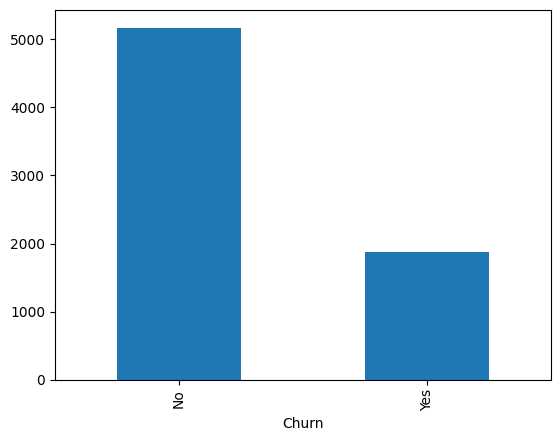

In [23]:
#Checking for class imbalances
df.Churn.value_counts().plot.bar()

In [24]:
#Checking if there are null values and converting the total charges into a numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


## Preprocessing for Model training

In [25]:
# Drop customerID and clean TotalCharges
df.drop("customerID", axis=1, inplace=True)
df.dropna(subset=["TotalCharges"], inplace=True)

# Split X and y
X = df.drop("Churn", axis=1)
y = df["Churn"].map({'No': 0, 'Yes': 1})

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define column groups FROM x_train ONLY
cat_col = [col for col in x_train.select_dtypes(include='object') if x_train[col].nunique() >= 2]
num_col = ["tenure", "MonthlyCharges", "TotalCharges"]

# Build transformer
transformer = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_col),
    ('scaler', StandardScaler(), num_col)
], remainder='drop')

# Fit on train, transform both
X_train_processed = transformer.fit_transform(x_train)
X_test_processed = transformer.transform(x_test)

# SMOTE
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)


In [26]:
#Fixed resampling errors
y_resampled.value_counts()

,count
Churn,
0,4130
1,4130


## Model training(Base Model)

### Desion tree Model

In [85]:
treeClassifier = DecisionTreeClassifier(random_state=42)
treeClassifier.fit(x_resampled, y_resampled)
treeClassifier.score(X_test_processed,y_test)

0.7114427860696517

### NN(Neural Network Model) Model

In [86]:
## Calculating the class weight and applying it in training to deal with class imbalances instead of smote
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.6809927360774818), np.int64(1): np.float64(1.8812709030100334)}


In [102]:
model = tf.keras.Sequential([

    tf.keras.layers.Dense(256, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Dense(32, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [103]:
#Createating callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [104]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

In [105]:
# NN model is trained on normal processed data instead of sampled data to avoid noise from smote
model.fit(X_train_processed,y_train, epochs = 100,class_weight=class_weights, validation_data=(X_test_processed,y_test), callbacks=[early_stopping,lr_scheduler],batch_size = 32)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6792 - auc: 0.7235 - loss: 0.6233 - val_accuracy: 0.7235 - val_auc: 0.8300 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7263 - auc: 0.8183 - loss: 0.5314 - val_accuracy: 0.7619 - val_auc: 0.8323 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7454 - auc: 0.8393 - loss: 0.4901 - val_accuracy: 0.7207 - val_auc: 0.8362 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7345 - auc: 0.8296 - loss: 0.5102 - val_accuracy: 0.7463 - val_auc: 0.8354 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7664 - auc: 0.8454 - loss: 0.4877 - val_accuracy: 0.7370 - val_auc: 0.8333 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7509 -

In [106]:
model.evaluate(X_test_processed,y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - auc: 0.8369 - loss: 0.5113


[0.5182267427444458, 0.7206823229789734, 0.8362228274345398]

##Hyper parameter tuning

### Hyper parameter tuning the Decision tree model

In [109]:
treeClassifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [114]:
#Best hyper parameter tuning grid for a descion tree model
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 5, 8, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', None],
    'class_weight': ['balanced'],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
}

In [115]:
grid = GridSearchCV(treeClassifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose = 2)
grid.fit(x_resampled, y_resampled)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
                         'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 8, 10, 12, 15],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best']},
             scoring='roc_auc', verbose=2)

In [116]:
grid.best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'splitter': 'best'}

In [120]:
#Creating a instance of the tree class that had the best outcome
best_Treeclassifier = grid.best_estimator_
best_Treeclassifier.fit(x_resampled, y_resampled)
best_Treeclassifier.score(X_test_processed,y_test)

0.7526652452025586

### Hyper parameter tuning